# CNNs

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
import string
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
!pip install -q -U keras-tuner
import keras_tuner as kt
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense, Embedding, GlobalMaxPool1D
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, TextVectorization, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

tf.keras.utils.set_random_seed(7)
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
pd.set_option('max_colwidth', 600)
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
print("Device:", tpu.master())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 133 kB 4.9 MB/s 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.9.105.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.9.105.210:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Device: grpc://10.9.105.210:8470


In [2]:
pip install clean-text[gpl]


     |████████████████████████████████| 175 kB 4.8 MB/s 
     |████████████████████████████████| 53 kB 1.3 MB/s 
     |████████████████████████████████| 235 kB 74.1 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=bed04eb53a759f821817504d2db1b184b8b7737fd041ff2445160066ddb5a9d7
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [3]:
from cleantext import clean

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [6]:
#mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
#Read in data
path_to_csv = '/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_4/cyberbullying_tweets.csv'
df=pd.read_csv(path_to_csv)

# Cleaning and Organizing Data

In [8]:
#looking at original data observation with emojis and urls

df.iloc[[706,1040]]

,tweet_text,cyberbullying_type
706,Uh. Why do they not make these for grownups? http://t.co/rHDOkljnDI,not_cyberbullying
1040,OMG 😱 I have a feeling I’m going to be overwhelmed 😱 by my emoticons in tomorrow’s #mkr 😱😰😅😜😀😩😨😱😱,not_cyberbullying


In [9]:
#function for cleaning data by removing emojies and urls with clean-text library. https://pypi.org/project/clean-text/

def cleaning_tweet_text(text):
    text= clean(text, no_emoji=True, no_urls=True, replace_with_url="") #removing emojies and urls 
    return text



In [10]:
#applying cleaning function to tweets
df["tweet_text"]=df["tweet_text"].apply(cleaning_tweet_text)

In [11]:
#checking the same observations as above after removing emojies and urls. We can see there are no longer
#any emojies or urls
df.iloc[[706,1040]]

,tweet_text,cyberbullying_type
706,uh. why do they not make these for grownups?,not_cyberbullying
1040,omg i have a feeling i'm going to be overwhelmed by my emoticons in tomorrow's #mkr,not_cyberbullying


In [12]:
#dropping duplicates
df = df.drop_duplicates(subset=['tweet_text'], keep='last')
df.shape

(45603, 2)

In [13]:
#checking distribution of cyberbyllying lables.
df["cyberbullying_type"].value_counts()

religion               7974
age                    7952
ethnicity              7946
other_cyberbullying    7720
gender                 7651
not_cyberbullying      6360
Name: cyberbullying_type, dtype: int64

In [14]:
#creating column of numerical cyberbullying labels.

label_number_mappings={"religion":0,
                       "age":1,
                       "gender":2,
                       "ethnicity":3,
                       "not_cyberbullying":4,
                       "other_cyberbullying":5
                      }
df["label_values"]=df["cyberbullying_type"].map(label_number_mappings)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [15]:
#checking if mapping was properly done
df["label_values"].value_counts()

0    7974
1    7952
3    7946
5    7720
2    7651
4    6360
Name: label_values, dtype: int64

In [16]:
#Splitting dataset into full_train and test sets, stratifying on labels.

X_train_full, X_test, y_train_full, y_test = train_test_split(df["tweet_text"], df["label_values"], test_size=5000, stratify=df["label_values"])

In [17]:
#making sure full train set is stratified properly
y_train_full.value_counts()

0    7100
1    7080
3    7075
5    6873
2    6812
4    5663
Name: label_values, dtype: int64

In [18]:
#making sure test set is stratified properly
y_test.value_counts()

0    874
1    872
3    871
5    847
2    839
4    697
Name: label_values, dtype: int64

In [19]:
#spliting full training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full,y_train_full, test_size=5000, stratify=y_train_full)

In [20]:
#making sure train set is stratified properly
y_train.value_counts()

0    6226
1    6208
3    6204
5    6026
2    5973
4    4966
Name: label_values, dtype: int64

In [21]:
#making sure validation set is stratified properly
y_val.value_counts()

0    874
1    872
3    871
5    847
2    839
4    697
Name: label_values, dtype: int64

# Data Preprocessing and Tokenization

In [22]:
#Tokenized text for X_train and X_val and X_test. Fit on train first then text_to_sequences on train,
#validation and test sets
max_tokens=30000
tokenizer =Tokenizer(num_words=max_tokens, oov_token="OOV")
tokenizer.fit_on_texts(X_train)
X_train_token=tokenizer.texts_to_sequences(X_train)
X_val_token=tokenizer.texts_to_sequences(X_val)
X_test_token=tokenizer.texts_to_sequences(X_test)

In [23]:
#check how many unique tokens
word_index=tokenizer.word_index
number_of_words=len(word_index)
print("Number of tokens",number_of_words )

Number of tokens 49098


In [24]:
#pad sequences for tokenized X_train, X_val and X_test
#set max length of text to 70 tokens
max_len=70
X_train_token_pad=pad_sequences(X_train_token, maxlen=max_len, padding="post", truncating="post")


X_val_token_pad=pad_sequences(X_val_token,maxlen= max_len , padding="post", truncating="post")
X_test_token_pad=pad_sequences(X_test_token,maxlen= max_len,padding="post", truncating="post")
X_val_token_pad.shape

(5000, 70)

# Helpful Model Fitting and Results Functions

In [25]:
#creating callback class to get the amount of seconds each epoch takes. Code from:
#https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

class EpochTimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


In [26]:

def compile_train_model(model, x_train, y_train, x_valid, y_valid, model_num, epochs=100, patience=3, optimizer='adam'):
    timestamp=int(time.time())
    epoch_times=EpochTimeHistory()
  
    # Compile
    model.compile(optimizer=optimizer,
                loss = 'SparseCategoricalCrossentropy',
                metrics=['accuracy'])

  # Train
    start_time = time.time()
    history = model.fit(
      x_train,
      y_train,
      epochs=epochs,
      batch_size=128,
      validation_data=(x_valid, y_valid),
      verbose=1,
      callbacks=[    
          EarlyStopping(monitor='val_accuracy', patience=patience, restore_best_weights=True, verbose=0),
         
        epoch_times]
       )
    end_time = time.time()
    second_elapsed = round(end_time - start_time)
    epoch_times_values =epoch_times.times
    print("\n")
    print(f'Finished model training in {second_elapsed}s')
    print(f'Average time to run each epoch is: {  np.round(np.mean(epoch_times.times[1:-1]),4) }') 
                                                                        
  

    return history, model   

In [27]:
#Classificatin report function
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))#included per class instruction 

In [28]:
#function to print out training and validation set loss and accuracy values of the best model
def loss_accuracy_values(model_history, model_num, epochs, patience=3):  
  if len(model_history.history["val_loss"])==epochs:
      print("Model Experiment {} Training Loss: ".format(model_num),np.round(model_history.history["loss"][-1],4))
      print("Model Experiment {} Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-1],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num),np.round(model_history.history["val_loss"][-1],4))
      print("Model Experiment {}  Validation Accuracy: ".format(model_num),np.round(model_history.history["val_accuracy"][-1],4))
  else:
      print("Model Experiment {}  Training Loss: ".format(model_num),np.round(model_history.history["loss"][-(1+patience)],4))
      print("Model Experiment {}  Training Accuracy: ".format(model_num),np.round(model_history.history["accuracy"][-(1+patience)],4))
      print("Model Experiment {}  Validation Loss: ".format(model_num), np.round(model_history.history["val_loss"][-(1+patience)],4))
      print("Model Experiment {}  Validation Accuracy:".format(model_num), np.round(model_history.history["val_accuracy"][-(1+patience)],4)) 

In [29]:
#creating function for charts of train vs validation accuracy and loss functions
def train_val_accuracy_and_loss_charts(model_history, model_num):
    model_df=pd.DataFrame(model_history.history)

    model_df[["loss","val_loss"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Loss".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    model_df[["accuracy","val_accuracy"]].plot(figsize=(9,7))
    plt.grid(True)
    plt.title("Model Experiment {}: Train vs. Validation - Accuracy".format(model_num), size =17)
    plt.xlabel("Epochs", size=15)

    plt.show()    

In [30]:
# Function for creating multi-class confusion matrix

#class names for confusion matrix
class_names = ["religion",
                       "age",
                       "gender",
                       "ethnicity",
                       "not_cyberbullying",
                       "other_cyberbullying"
]



def confusion_matrix_multi_class(model_for_matrix,test_set, actual_test_labels, model_num):
    #predicting test set with model for confusion matrix and setting as sparse with argmax
    confusion_matrix_predictions=model_for_matrix.predict(test_set).argmax(axis=1)



    #creating confusion matrix - using test set labels as they were already sparse before one-hot encoding
    confusion_matrix_for_model = confusion_matrix( actual_test_labels ,  confusion_matrix_predictions)


    confusion_matrix_df = pd.DataFrame(confusion_matrix_for_model,
                    
                     index=class_names,
                     columns=class_names)

    #Plotting the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="rocket_r")
    plt.title('Confusion Matrix - Model Experiment {}'.format(model_num), size=17)
    plt.ylabel('Actual Labels', size=15)
    plt.xlabel('Predicted Labels',size=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

# GloVe Embeddings: Parsing and Creating Embedding Matrix

In [31]:

path_to_glove_file = '/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_4/glove.twitter.27B.100d.txt'
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ") # np.dtype('f') returns dtype('float32')
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 1193514 word vectors.


In [32]:
embedding_dim = 100



# Prepare a matrix that we’ll fill with the GloVe vectors.
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Fill entry i in the matrix with the word vector for index i.
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Words not found in the embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

# Experiment 6_A - CNN - Hyperparameter Tunning - up to 3 Conv1D/MaxPooling Pairs (Global pooling after last Conv1D layer) with Dropout

In [34]:
#Experiment 6_A model 
#create model for KerasTuner hyperparameter testing
def create_model_exp_6_A(hp):
    
    model=Sequential()
    #tunning for different number of embedding output dimensions min of 100, max of 400 and any in between by multiples of 100
    model.add(Embedding(input_dim=max_tokens, output_dim= hp.Int(f"Embedding_Output_Dimension", min_value=100, max_value=400, step=100), mask_zero=True))
    #tunning for a choice of 1,2, or 3 Convolutional layers
    
    for i in range(hp.Int("Number_Conv_layers",1,2)):
        #within each layer testing for a min of 128 filters, a max of 512 filters and any in between by 
        #multiples of 128. Also testing kernel sized 3, 4, 5. 
        model.add(Conv1D(filters=hp.Int("Conv_Filters_{}".format(i), min_value=128, max_value=512, step=128),
                        kernel_size=hp.Int('Conv_kernel_size_{}'.format(i), 5, 25),
                        padding='same',
                        activation='relu'))
        #testing strides of 1 or 2 for max pooling
        model.add(MaxPooling1D(2, 
                  strides=hp.Int("Max_Pool_strides_{}".format(i), 1,2     )))
        #testing for dropout of values 0.1 or 0.40 after every MaxPool layer
        model.add(Dropout (hp.Float("Conv_Dropout_{}".format(i), min_value=0.10, max_value=0.40, step=0.10)))
        
    #testing for number of nodes from 128 to 512 by multiples of 128 for the last convolutional layer
    model.add(Conv1D(filters=hp.Int("Conv_Filters_{}".format(i+1), min_value=128, max_value=512, step=128),
                        kernel_size=hp.Int('Conv_kernel_size_{}'.format(i+1), 5, 25),
                        padding='same',
                        activation='relu'))
    model.add(GlobalMaxPooling1D())
    
    #testing for dropout of values 0.1 or 0.40 for GlobalMaxPooling1D
    model.add(Dropout (hp.Float("Dropout_GlobalMaxPooling1D", min_value=0.10, max_value=0.40, step=0.10)))
    model.add(Dense(6, activation = "softmax"))
    
    
    #testing for optimizer choice of adam, sgd, or rmsprop
    model.compile(optimizer=hp.Choice("optimizer", ["adam", "sgd", "rmsprop"]), \
                                            loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model

create_model_exp_6_A(kt.HyperParameters())

In [35]:
strategy_exp_6_A  = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [36]:
#creating Bayesian Optimization for KerasTuner
tuner_exp_6_A = kt.BayesianOptimization(
    hypermodel=create_model_exp_6_A,
    objective="val_accuracy",
    max_trials=15,
    overwrite=True,
    distribution_strategy=strategy_exp_6_A,
    directory='/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_4/keras_tuner_out',
    project_name="exp_6_a")

In [37]:
#setting epochs, patience and early stopping
epochs=30
patience=3
model_number="6_A"
early_stopping= EarlyStopping(monitor='val_accuracy',patience=patience, restore_best_weights=True )

#tunning the model
tuner_exp_6_A.search(X_train_token_pad, y_train, epochs=epochs, batch_size=128, validation_data=(X_val_token_pad, y_val), callbacks= [early_stopping])


Trial 15 Complete [00h 00m 43s]
val_accuracy: 0.8733999729156494

Best val_accuracy So Far: 0.8797999620437622
Total elapsed time: 00h 19m 50s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [38]:
#getting best hyperparameters for model 
best_hyper_parameters_exp_6_A=tuner_exp_6_A.get_best_hyperparameters(num_trials=1)[0]

#function to print out best parameters depending on how many Conv layers there are
def best_model_hyperparameters_6_A(bhp):
    print("Embedding_Output_Dimension: {}".format(bhp.get('Embedding_Output_Dimension')))
    num_conv_layers=bhp.get('Number_Conv_layers')
    print("Number of layers: {}".format(num_conv_layers+1))
    print("\n")
    for i in range(0,num_conv_layers):
        
        print("Number of filters in Conv_Layer_{}:".format(i), bhp.get("Conv_Filters_{}".format(i)))
        print("Kernel size for Conv Layer_{}:".format(i), bhp.get("Conv_kernel_size_{}".format(i)))
        print("Strides for Max Pooling Layer_{}:".format(i), bhp.get("Max_Pool_strides_{}".format(i)))
        print("Dropout in Conv layer_{}:".format(i), bhp.get("Conv_Dropout_{}".format(i)))
        print("\n")
    print("Number of filters in Conv_Layer_{}:".format(i+1), bhp.get("Conv_Filters_{}".format(i)))
    print("Kernel size for Conv Layer_{}:".format(i+1), bhp.get("Conv_kernel_size_{}".format(i)))
    print('Dropout After GLobalMaxPooling1D Layer:', bhp.get('Dropout_GlobalMaxPooling1D'))
    print("\n")
    print("Optimizer Used: {}".format(bhp.get('optimizer')))                                                           

#printing out best model hyperparameters
best_model_hyperparameters_6_A(best_hyper_parameters_exp_6_A)  

Embedding_Output_Dimension: 300
Number of layers: 2


Number of filters in Conv_Layer_0: 512
Kernel size for Conv Layer_0: 16
Strides for Max Pooling Layer_0: 2
Dropout in Conv layer_0: 0.2


Number of filters in Conv_Layer_1: 512
Kernel size for Conv Layer_1: 16
Dropout After GLobalMaxPooling1D Layer: 0.2


Optimizer Used: rmsprop


In [39]:
#setting up TPU strategy to run best 5b_2 model
strategy_6_A_best = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [43]:
#getting paremeters of best model
model_exp_6_A_best_params = tuner_exp_6_A.get_best_hyperparameters(2)
# Building model exp_6_A with best hyper parameters
with strategy_6_A_best.scope():
    model_exp_6_A_best = create_model_exp_6_A(model_exp_6_A_best_params[0])


In [44]:


# Running best model 6_A to get the time to run an epoch and time to run the whole model. Test set metrics will be 
#based of this model run.
epochs=30
patience=3
model_number="6_A"
history_exp_6_A, model_exp_6_A = compile_train_model(model_exp_6_A_best,
                                    X_train_token_pad,y_train,
                                     X_val_token_pad,y_val, model_number, epochs,patience=patience,
                                    optimizer="rmsprop")

Epoch 1/30
  4/279 [..............................] - ETA: 6s - loss: 2.5861 - accuracy: 0.1973   WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0017s vs `on_train_batch_end` time: 1.0114s). Check your callbacks.


279/279 [==============================] - 25s 61ms/step - loss: 0.5119 - accuracy: 0.8061 - val_loss: 0.3494 - val_accuracy: 0.8738
Epoch 2/30
279/279 [==============================] - 7s 24ms/step - loss: 0.2635 - accuracy: 0.9076 - val_loss: 0.4512 - val_accuracy: 0.8430
Epoch 3/30
279/279 [==============================] - 7s 24ms/step - loss: 0.1652 - accuracy: 0.9435 - val_loss: 0.4360 - val_accuracy: 0.8682
Epoch 4/30
279/279 [==============================] - 7s 25ms/step - loss: 0.0851 - accuracy: 0.9715 - val_loss: 0.5502 - val_accuracy: 0.8630


Finished model training in 46s
Average time to run each epoch is: 6.844


In [45]:
model_exp_6_A.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         9000000   
                                                                 
 conv1d_4 (Conv1D)           (None, None, 512)         2458112   
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 512)        0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, None, 512)         0         
                                                                 
 conv1d_5 (Conv1D)           (None, None, 384)         1180032   
                                                                 
 global_max_pooling1d_2 (Glo  (None, 384)              0         
 balMaxPooling1D)                                     

In [46]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_6_A, model_number, epochs, patience=patience)

Model Experiment 6_A  Training Loss:  0.5119
Model Experiment 6_A  Training Accuracy:  0.8061
Model Experiment 6_A  Validation Loss:  0.3494
Model Experiment 6_A  Validation Accuracy: 0.8738


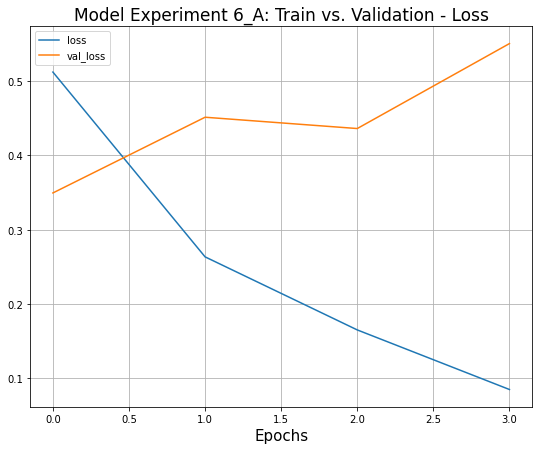

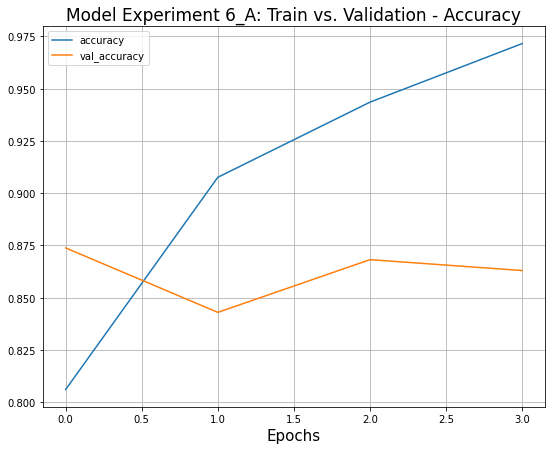

In [47]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_6_A, model_number)

In [48]:
#creating  classification report

#getting predictions

model_exp_6_A_predictions=model_exp_6_A.predict(X_test_token_pad).argmax(axis=1)
print_validation_report(y_test, model_exp_6_A_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       874
           1       0.98      0.95      0.97       872
           2       0.93      0.84      0.88       839
           3       0.97      0.98      0.97       871
           4       0.64      0.68      0.66       697
           5       0.72      0.77      0.75       847

    accuracy                           0.87      5000
   macro avg       0.87      0.86      0.86      5000
weighted avg       0.87      0.87      0.87      5000

Accuracy Score: 0.869
Root Mean Square Error: 0.8251060537894507


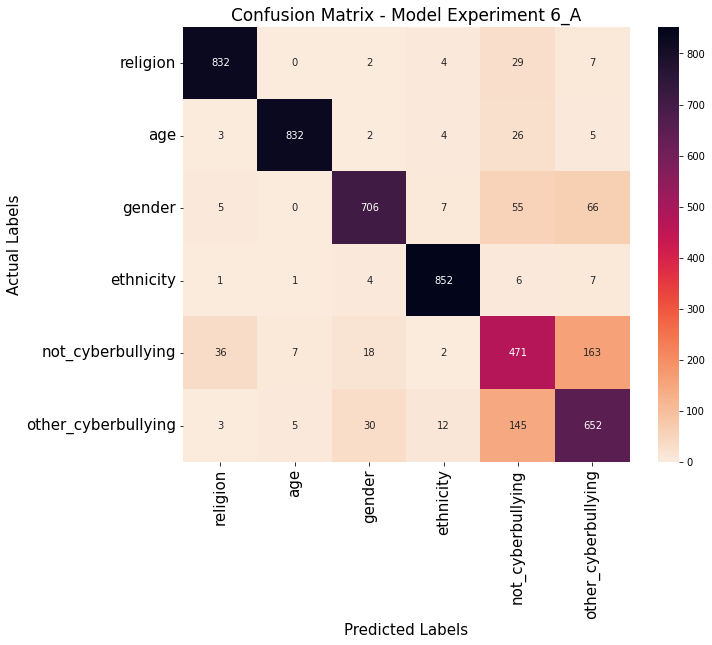

In [49]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_6_A, X_test_token_pad, y_test, model_number)

# Experiment 6_B - GloVe Pre-trained Embeddings-  CNN - Hyperparameter Tunning - up to 3 Conv1D/MaxPooling Pairs (Global pooling after last Conv1D layer) with Dropout

In [ ]:
keras.backend.clear_session()

In [50]:
#Experiment 6_B model 
#create model for KerasTuner hyperparameter testing
def create_model_exp_6_B(hp):
    
    model=Sequential()
    
    model.add(Embedding(max_tokens,embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False, mask_zero=True ))
    #tunning for a choice of 2 or 3 Convolutional layers
    
    for i in range(hp.Int("Number_Conv_layers",1,2)):
        #within each layer testing for a min of 128 filters, a max of 512 filters and any in between by 
        #multiples of 128. Also testing kernel sized 3, 4, 5. 
        model.add(Conv1D(filters=hp.Int("Conv_Filters_{}".format(i), min_value=128, max_value=512, step=128),
                        kernel_size=hp.Int('Conv_kernel_size_{}'.format(i), 5, 25),
                        padding='same',
                        activation='relu'))
        #testing strides of 1 or 2 for max pooling
        model.add(MaxPooling1D(2, 
                  strides=hp.Int("Max_Pool_strides_{}".format(i), 1,2     )))
        #testing for dropout of values 0.1 or 0.40 after every MaxPool layer
        model.add(Dropout (hp.Float("Conv_Dropout_{}".format(i), min_value=0.10, max_value=0.40, step=0.10)))
        
    #testing for number of nodes from 128 to 512 by multiples of 128 for the last convolutional layer
    model.add(Conv1D(filters=hp.Int("Conv_Filters_{}".format(i+1), min_value=128, max_value=512, step=128),
                        kernel_size=hp.Int('Conv_kernel_size_{}'.format(i+1), 5, 25),
                        padding='same',
                        activation='relu'))
    model.add(GlobalMaxPooling1D())
    
    #testing for dropout of values 0.1 or 0.40 for GlobalMaxPooling1D
    model.add(Dropout (hp.Float("Dropout_GlobalMaxPooling1D", min_value=0.10, max_value=0.40, step=0.10)))
    model.add(Dense(6, activation = "softmax"))
    
    
    #testing for optimizer choice of adam, sgd, or rmsprop
    model.compile(optimizer=hp.Choice("optimizer", ["adam", "sgd", "rmsprop"]), \
                                            loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model

create_model_exp_6_B(kt.HyperParameters())

In [51]:
strategy_exp_6_B  = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [52]:
#creating Bayesian Optimization for KerasTuner
tuner_exp_6_B = kt.BayesianOptimization(
    hypermodel=create_model_exp_6_B,
    objective="val_accuracy",
    max_trials=15,
    overwrite=True,
    distribution_strategy=strategy_exp_6_B,
    directory='/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_4/keras_tuner_out',
    project_name="exp_6_B")

In [53]:
#setting epochs, patience and early stopping
epochs=30
patience=3
model_number="6_B"
early_stopping= EarlyStopping(monitor='val_accuracy',patience=patience, restore_best_weights=True )

#tunning the model
tuner_exp_6_B.search(X_train_token_pad, y_train, epochs=epochs, batch_size=128, validation_data=(X_val_token_pad, y_val), callbacks= [early_stopping])


Trial 15 Complete [00h 00m 40s]
val_accuracy: 0.8671999573707581

Best val_accuracy So Far: 0.8693999648094177
Total elapsed time: 00h 17m 16s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [54]:
#getting best hyperparameters for model 
best_hyper_parameters_exp_6_B=tuner_exp_6_B.get_best_hyperparameters(num_trials=1)[0]

#function to print out best parameters depending on how many Conv layers there are
def best_model_hyperparameters_6_B(bhp):
    
    num_conv_layers=bhp.get('Number_Conv_layers')
    print("Number of layers: {}".format(num_conv_layers+1))
    print("\n")
    for i in range(0,num_conv_layers):
        
        print("Number of filters in Conv_Layer_{}:".format(i), bhp.get("Conv_Filters_{}".format(i)))
        print("Kernel size for Conv Layer_{}:".format(i), bhp.get("Conv_kernel_size_{}".format(i)))
        print("Strides for Max Pooling Layer_{}:".format(i), bhp.get("Max_Pool_strides_{}".format(i)))
        print("Dropout in Conv layer_{}:".format(i), bhp.get("Conv_Dropout_{}".format(i)))
        print("\n")
    print("Number of filters in Conv_Layer_{}:".format(i+1), bhp.get("Conv_Filters_{}".format(i)))
    print("Kernel size for Conv Layer_{}:".format(i+1), bhp.get("Conv_kernel_size_{}".format(i)))
    print('Dropout After GLobalMaxPooling1D Layer:', bhp.get('Dropout_GlobalMaxPooling1D'))
    print("\n")
    print("Optimizer Used: {}".format(bhp.get('optimizer')))                                                           

#printing out best model hyperparameters
best_model_hyperparameters_6_B(best_hyper_parameters_exp_6_B)  

Number of layers: 2


Number of filters in Conv_Layer_0: 512
Kernel size for Conv Layer_0: 5
Strides for Max Pooling Layer_0: 2
Dropout in Conv layer_0: 0.4


Number of filters in Conv_Layer_1: 512
Kernel size for Conv Layer_1: 5
Dropout After GLobalMaxPooling1D Layer: 0.1


Optimizer Used: adam


In [55]:
#setting up TPU strategy to run best 6_B model
strategy_6_B_best = tf.distribute.TPUStrategy(tpu) 

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [56]:
#getting paremeters of best model
model_exp_6_B_best_params = tuner_exp_6_B.get_best_hyperparameters(2)
# Building model exp_6_B with best hyper parameters
with strategy_6_B_best.scope():
    model_exp_6_B_best = create_model_exp_6_B(model_exp_6_B_best_params[0])


In [57]:


# Running best model 6_B to get the time to run an epoch and time to run the whole model. Test set metrics will be 
#based of this model run.
epochs=30
patience=3
model_number="6_B"
history_exp_6_B, model_exp_6_B = compile_train_model(model_exp_6_B_best,
                                    X_train_token_pad,y_train,
                                     X_val_token_pad,y_val, model_number, epochs,patience=patience,
                                    optimizer="adam")

Epoch 1/30
  4/279 [..............................] - ETA: 4s - loss: 3.4348 - accuracy: 0.1719   WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0015s vs `on_train_batch_end` time: 0.3652s). Check your callbacks.


279/279 [==============================] - 13s 32ms/step - loss: 0.6718 - accuracy: 0.7708 - val_loss: 0.4276 - val_accuracy: 0.8438
Epoch 2/30
279/279 [==============================] - 5s 19ms/step - loss: 0.3814 - accuracy: 0.8594 - val_loss: 0.3827 - val_accuracy: 0.8586
Epoch 3/30
279/279 [==============================] - 6s 20ms/step - loss: 0.3255 - accuracy: 0.8776 - val_loss: 0.3742 - val_accuracy: 0.8640
Epoch 4/30
279/279 [==============================] - 5s 18ms/step - loss: 0.2738 - accuracy: 0.8959 - val_loss: 0.3655 - val_accuracy: 0.8672
Epoch 5/30
279/279 [==============================] - 5s 18ms/step - loss: 0.2247 - accuracy: 0.9180 - val_loss: 0.3807 - val_accuracy: 0.8646
Epoch 6/30
279/279 [==============================] - 5s 18ms/step - loss: 0.1810 - accuracy: 0.9329 - val_loss: 0.4246 - val_accuracy: 0.8564
Epoch 7/30
279/279 [==============================] - 5s 18ms/step - loss: 0.1444 - accuracy: 0.9463 - val_loss: 0.4428 - val_accuracy: 0.8582


Finishe

In [58]:
model_exp_6_B.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         3000000   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 512)         256512    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 512)        0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, None, 512)         0         
                                                                 
 conv1d_3 (Conv1D)           (None, None, 512)         1573376   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 512)              0         
 balMaxPooling1D)                                     

In [59]:
#printing train and validation loss and accuracy for the model

loss_accuracy_values(history_exp_6_B, model_number, epochs, patience=patience)

Model Experiment 6_B  Training Loss:  0.2738
Model Experiment 6_B  Training Accuracy:  0.8959
Model Experiment 6_B  Validation Loss:  0.3655
Model Experiment 6_B  Validation Accuracy: 0.8672


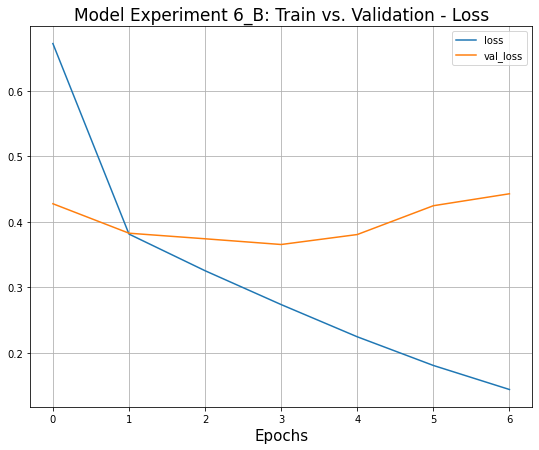

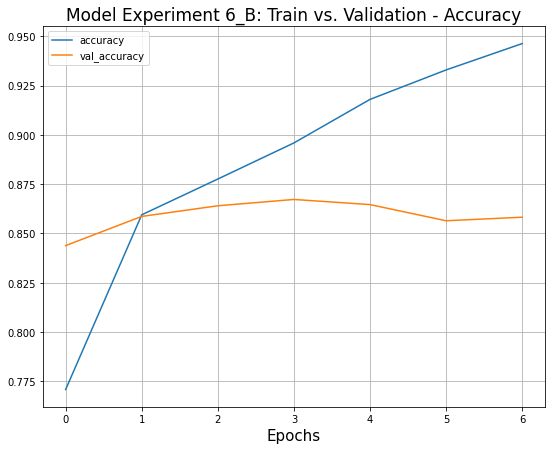

In [60]:
#printing charts of  train vs validation accuracy and loss functions

train_val_accuracy_and_loss_charts(history_exp_6_B, model_number)

In [61]:
#creating  classification report

#getting predictions

model_exp_6_B_predictions=model_exp_6_B.predict(X_test_token_pad).argmax(axis=1)
print_validation_report(y_test, model_exp_6_B_predictions)

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       874
           1       0.98      0.98      0.98       872
           2       0.84      0.86      0.85       839
           3       0.98      0.96      0.97       871
           4       0.73      0.54      0.62       697
           5       0.67      0.81      0.73       847

    accuracy                           0.86      5000
   macro avg       0.86      0.85      0.85      5000
weighted avg       0.86      0.86      0.86      5000

Accuracy Score: 0.8602
Root Mean Square Error: 0.8996666049153986


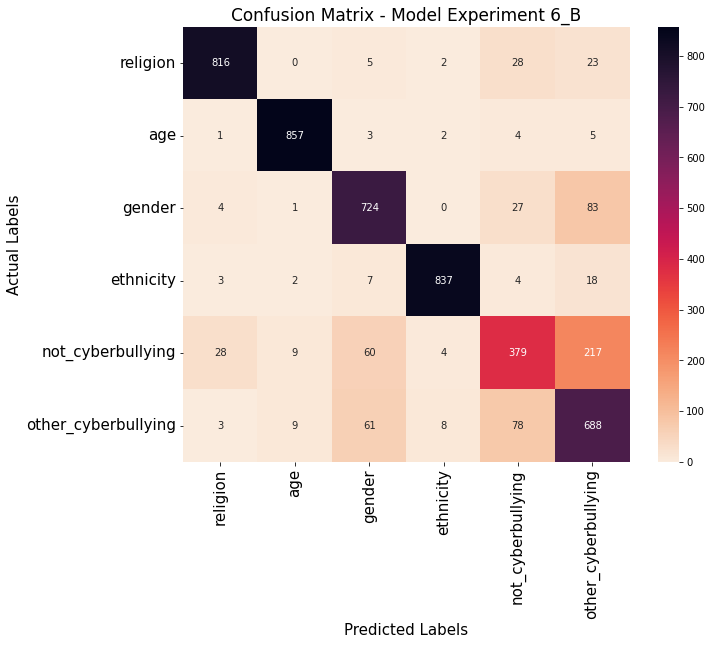

In [62]:
#printing out confusion matrix
confusion_matrix_multi_class(model_exp_6_B, X_test_token_pad, y_test, model_number)